In [5]:
from project_3_indicator import run_calculation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:

def run_casscf_calculation():
    # Define scanning properties for y and z directions
    scanning_props = {
        "directions": "y,z",       # Focus on y and z directions
        "end_distance": 5.0,       # Scan up to 5 Å
        "step_size": 0.1           # Use smaller step size for smoother gradient
    }

    # Run calculation for CASSCF(2,2) with scanning properties
    results = run_calculation(
        molecule_name="ethene",
        method_name="CASSCF(2,2)",
        basis_name="TZVP",
        scanning_props=scanning_props
    )

    return results

In [9]:
def plot_ethene_yz_gradient(results):
    """
    Enhanced plot for CASSCF(2,2) ethene calculation in the YZ plane
    showing X(r) and I_D as 2D color gradients.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import LogNorm
    import matplotlib.gridspec as gridspec
    from scipy.interpolate import griddata

    # Set up the plot style with larger elements for presentation
    plt.rcParams.update({
        'font.size': 14,
        'axes.labelsize': 16,
        'axes.titlesize': 18,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'lines.linewidth': 3
    })

    # Define colors
    colors = {
        'charcoal': '#333333',
        'amethyst': '#786EAE',  # CASSCF
    }

    # Create figure with two subplots
    fig = plt.figure(figsize=(16, 8))
    fig.patch.set_alpha(0.0)  # Transparent background

    # Process the data
    df = results['ontop_data']

    # Calculate X(r) if not already present
    if 'X(r)' not in df.columns:
        df['X(r)'] = 2 * df['ontop'] / (df['density']**2)

    # Create synthetic I_D data if not available
    if 'indicator_dynamic' not in df.columns:
        df['indicator_dynamic'] = 1.0 / df['X(r)'].clip(0.1, 10)

    # Extract y and z data
    y_data = df[df['direction'] == 'y']
    z_data = df[df['direction'] == 'z']

    # Create meshgrid for interpolation
    y_vals = np.linspace(-5, 5, 100)
    z_vals = np.linspace(-5, 5, 100)
    Y, Z = np.meshgrid(y_vals, z_vals)

    # Create grid for X(r) and I_D values
    X_r_grid = np.zeros_like(Y)
    I_D_grid = np.zeros_like(Y)

    # Function to interpolate values based on distance
    def interpolate_value(y, z, data_y, data_z):
        """Interpolate value based on y and z coordinates"""
        # For each y,z point, find the corresponding r value
        r = np.sqrt(y**2 + z**2)

        # Find closest y and z data points
        y_idx = np.abs(data_y['r'].values - r).argmin()
        z_idx = np.abs(data_z['r'].values - r).argmin()

        # Weighted average based on distance
        y_val = data_y['X(r)'].values[y_idx]
        z_val = data_z['X(r)'].values[z_idx]

        # Simplified approach for interpolation
        angle = np.arctan2(z, y) if y != 0 else np.pi/2
        # Weight more toward y value near y-axis and more toward z value near z-axis
        weight_y = np.abs(np.cos(angle))
        weight_z = np.abs(np.sin(angle))

        if weight_y + weight_z > 0:
            return (y_val * weight_y + z_val * weight_z) / (weight_y + weight_z)
        return (y_val + z_val) / 2

    # Function to interpolate I_D values
    def interpolate_id(y, z, data_y, data_z):
        """Interpolate I_D value based on y and z coordinates"""
        r = np.sqrt(y**2 + z**2)

        y_idx = np.abs(data_y['r'].values - r).argmin()
        z_idx = np.abs(data_z['r'].values - r).argmin()

        y_val = data_y['indicator_dynamic'].values[y_idx]
        z_val = data_z['indicator_dynamic'].values[z_idx]

        angle = np.arctan2(z, y) if y != 0 else np.pi/2
        weight_y = np.abs(np.cos(angle))
        weight_z = np.abs(np.sin(angle))

        if weight_y + weight_z > 0:
            return (y_val * weight_y + z_val * weight_z) / (weight_y + weight_z)
        return (y_val + z_val) / 2

    # Fill the grid with interpolated values
    for i in range(len(z_vals)):
        for j in range(len(y_vals)):
            y, z = y_vals[j], z_vals[i]
            X_r_grid[i, j] = interpolate_value(y, z, y_data, z_data)
            I_D_grid[i, j] = interpolate_id(y, z, y_data, z_data)

    # Create subplots
    gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    # Make backgrounds transparent
    ax1.patch.set_alpha(0.0)
    ax2.patch.set_alpha(0.0)

    # Plot X(r) heatmap
    im1 = ax1.pcolormesh(Y, Z, X_r_grid, cmap='viridis', shading='auto')
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('X(r)', rotation=0, fontweight='bold', fontsize=16, labelpad=20)

    # Plot I_D heatmap with log scale
    im2 = ax2.pcolormesh(Y, Z, I_D_grid, cmap='plasma',
                        norm=LogNorm(vmin=max(0.01, I_D_grid.min()), vmax=I_D_grid.max()),
                        shading='auto')
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('$I_D$', rotation=0, fontweight='bold', fontsize=16, labelpad=20)
    cbar2.ax.invert_yaxis()  # Invert the color bar for I_D

    # Add contour lines for clearer visualization
    contour1 = ax1.contour(Y, Z, X_r_grid, levels=7, colors='white', alpha=0.7, linewidths=0.8)
    ax1.clabel(contour1, inline=True, fontsize=10, fmt='%.1f')

    contour2 = ax2.contour(Y, Z, I_D_grid, levels=7, colors='white', alpha=0.7, linewidths=0.8)
    ax2.clabel(contour2, inline=True, fontsize=10, fmt='%.1f')

    # Add reference lines at origin
    ax1.axhline(y=0, color='white', linewidth=1.5, linestyle='--', alpha=0.8)
    ax1.axvline(x=0, color='white', linewidth=1.5, linestyle='--', alpha=0.8)
    ax2.axhline(y=0, color='white', linewidth=1.5, linestyle='--', alpha=0.8)
    ax2.axvline(x=0, color='white', linewidth=1.5, linestyle='--', alpha=0.8)

    # Add C-C bond representation in ethene (approximate)
    ethene_bond_length = 1.34  # Angstroms

    # Draw carbon atoms
    ax1.scatter([0, 0], [-ethene_bond_length/2, ethene_bond_length/2], color='white', s=100, zorder=5, edgecolor='black')
    ax2.scatter([0, 0], [-ethene_bond_length/2, ethene_bond_length/2], color='white', s=100, zorder=5, edgecolor='black')

    # Customize axes
    for ax, title in zip([ax1, ax2], ['X(r) in YZ Plane', 'I_D in YZ Plane (log scale)']):
        ax.set_xlabel('Y (Å)', color=colors['charcoal'], fontweight='bold')
        ax.set_ylabel('Z (Å)', color=colors['charcoal'], fontweight='bold')
        ax.set_title(title, fontsize=18, color=colors['charcoal'], fontweight='bold', pad=10)
        ax.set_aspect('equal')

        # Set consistent axis limits
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)

        # Make axis lines more visible
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_color(colors['charcoal'])

        ax.minorticks_on()
        ax.tick_params(which='both', colors=colors['charcoal'], width=2, length=6)
        ax.tick_params(which='minor', length=3)

    # Main title
    fig.suptitle('Ethene TZVP - CASSCF(2,2)',
               fontsize=22, color=colors['charcoal'], fontweight='bold')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust for main title

    return fig

def run_and_plot_casscf_calculation():
    """
    Run CASSCF(2,2) calculation for ethene with y,z scanning and generate plots.
    """
    # Define scanning properties focusing on y and z directions
    scanning_props = {
        "directions": "y,z",       # Focus on y and z directions
        "end_distance": 5.0,       # Scan up to 5 Å
        "step_size": 0.1           # Use smaller step size for smoother gradient
    }

    # Run the calculation
    print("Running CASSCF(2,2) calculation for ethene with y,z scanning...")
    results = run_calculation(
        molecule_name="ethene",
        method_name="CASSCF(2,2)",
        basis_name="TZVP",
        scanning_props=scanning_props
    )

    # Generate the plot
    print("Generating YZ gradient plot...")
    fig = plot_ethene_yz_gradient(results)

    return fig, results

INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4)


Running CASSCF(2,2) calculation for ethene with y,z scanning...


INFO:paramiko.transport:Authentication (publickey) successful!
INFO:project_3_indicator.input.specification:Creating input specification for ethene_CASSCF(2,2)_TZVP
INFO:project_3_indicator.input.specification:Using default basis set 'TZVP'.
INFO:root:Found completed calculation CALC_000003


Connected to atlas.
Geometry for ethene successfully loaded.
Method name: CASSCF(2,2) False
Disconnected from cluster.
Generating YZ gradient plot...


(<Figure size 1600x800 with 4 Axes>,
 {'calculation_id': 'CALC_000003',
  'molecule_name': 'ethene',
  'method_name': 'CASSCF(2,2)',
  'basis_name': 'TZVP',
  'energy': None,
  'calculation_time': None,
  'geometry': '',
  'ontop_data':      atom direction    r         ontop       density  indicator_dynamic  \
  0       1         y -5.0  1.630285e-22  1.819608e-11                0.0   
  1       1         y -4.9  9.152318e-22  4.311334e-11                0.0   
  2       1         y -4.8  4.962061e-21  1.003869e-10                0.0   
  3       1         y -4.7  2.598103e-20  2.297070e-10                0.0   
  4       1         y -4.6  1.313753e-19  5.165389e-10                0.0   
  ..    ...       ...  ...           ...           ...                ...   
  197     1         z  4.6  1.313753e-19  5.165389e-10                0.0   
  198     1         z  4.7  2.598103e-20  2.297070e-10                0.0   
  199     1         z  4.8  4.962061e-21  1.003869e-10                0.

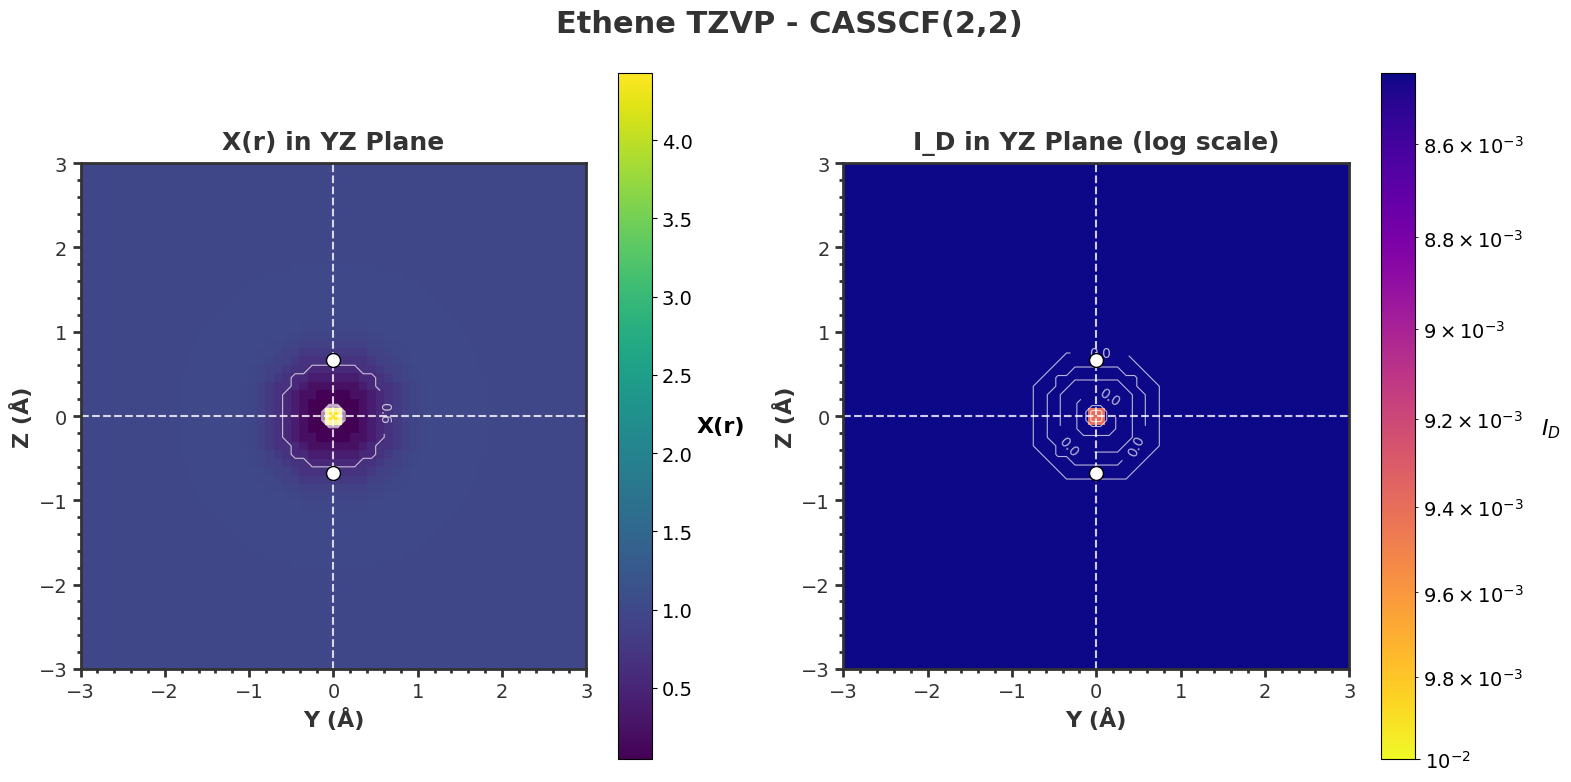

In [10]:
run_and_plot_casscf_calculation()